In [60]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

# SK-learn libraries for evaluation.
from sklearn.metrics import make_scorer

# Set randomizer seed
np.random.seed(0)

In [2]:
## Prepare data for model fitting

# Train and test sets on local machines
file_paths = ['~/datasets/bike/train.csv', '~/datasets/bike/test.csv']

# Define function to clean train and test data
def clean_data(path):
    """
    Input: path of csv files (train or test)
    Output: cleaned dataframe
    """
    df = pd.read_csv(path, parse_dates=[0])
    # Split datetime up into 3 components (year, dayofyear, hour)
    df.insert(1, "year", df["datetime"].dt.year)
    df.insert(2, "dayofyear", df["datetime"].dt.dayofyear)
    df.insert(3, "hour", df["datetime"].dt.hour)    
    # Fill in missing values in humidity and windspeed
    df.loc[df["humidity"]==0, "humidity"] = np.nan
    df.loc[df["windspeed"]==0, "windspeed"] = np.nan    
    # Fill forward first, then, backwards (for first few missing values)
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df

# Clean train and test csv files
df_train = clean_data(file_paths[0])
df_test = clean_data(file_paths[1])

# Get train feature names (excluding datetime, casual, registered, count)
print ("Feature names: ")
print (df_train.columns.values[1:-3])
# Print out first 5 training examples
print ("\nFirst 5 examples: ")
print (df_train.head())

# Extract numerical features
num_data = df_train.iloc[:, 1:].values
X, Y = num_data[:, :-3], num_data[:, -1]
test_data = df_test.iloc[:, 1:].values

# Split all training data into train set and dev set (about 7:1 ratio)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
print ("All train data: {}".format(X.shape))
train_data, train_labels = X[:9500], Y[:9500]
dev_data, dev_labels = X[9500:], Y[9500:]

# Array sizes
print ("Train data: {}".format(train_data.shape))
print ("Dev data: {}".format(dev_data.shape))
print ("Test data: {}".format(test_data.shape))

Feature names: 
['year' 'dayofyear' 'hour' 'season' 'holiday' 'workingday' 'weather' 'temp'
 'atemp' 'humidity' 'windspeed']

First 5 examples: 
             datetime  year  dayofyear  hour  season  holiday  workingday  \
0 2011-01-01 00:00:00  2011          1     0       1        0           0   
1 2011-01-01 01:00:00  2011          1     1       1        0           0   
2 2011-01-01 02:00:00  2011          1     2       1        0           0   
3 2011-01-01 03:00:00  2011          1     3       1        0           0   
4 2011-01-01 04:00:00  2011          1     4       1        0           0   

   weather  temp   atemp  humidity  windspeed  casual  registered  count  
0        1  9.84  14.395        81     6.0032       3          13     16  
1        1  9.02  13.635        80     6.0032       8          32     40  
2        1  9.02  13.635        80     6.0032       5          27     32  
3        1  9.84  14.395        75     6.0032       3          10     13  
4        1  9.84 

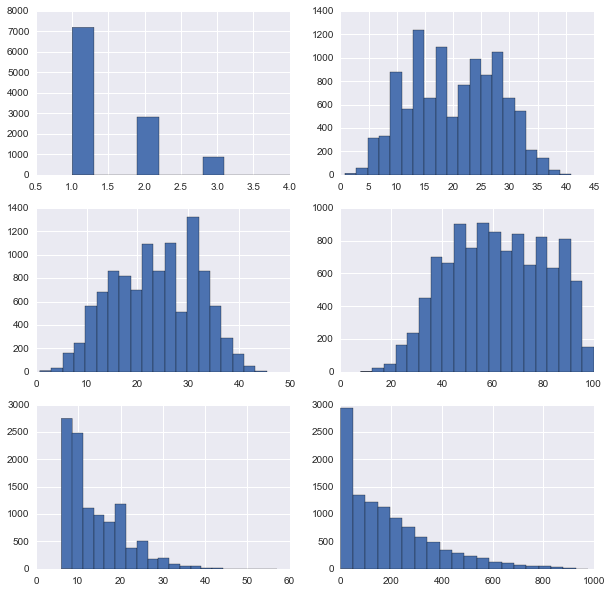

In [3]:
# Histograms for cetain variables
plt.figure(figsize=(10,10))
plt.subplot(321)
df_train["weather"].hist()
plt.subplot(322)
df_train["temp"].hist(bins=20)
plt.subplot(323)
df_train["atemp"].hist(bins=20)
plt.subplot(324)
df_train["humidity"].hist(bins=20) # missing values
plt.subplot(325)
df_train["windspeed"].hist(bins=20) # missing values
plt.subplot(326)
df_train["count"].hist(bins=20)

In [31]:
# Evaluation: Root Mean Squared Logarithmic Error (RMSLE)
def RMSLE(actual, predicted):
    """
    Inputs: actual counts, predicted counts
    Outputs: Root Mean Squared Logarithmic Error
    """
    return np.sqrt(np.mean(np.square(np.log(predicted+1) - np.log(actual+1))))

# Make a scoring object for GridSearch to use
RMSLE_scorer = make_scorer(RMSLE, greater_is_better=False)

In [35]:
# Linear Regression
# Fit a simple regression model using all training data
lr_model = LinearRegression()
lr_model.fit(train_data, train_labels)
preds = lr_model.predict(dev_data)

# Compute baseline score (using the mean as the base model)
base_preds = np.repeat(np.mean(train_labels), dev_labels.shape)
print ("RMSLE(baseline): {}".format(RMSLE(dev_labels, base_preds)))

# Now try linear regression model
# Predictions cannot be negative, convert negative predictions to zero
preds[preds<0] = 0
print ("RMSLE: {}".format(RMSLE(dev_labels, preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels, preds)))

RMSLE(baseline): 1.5629246036
RMSLE: 1.28782961803
R-square on dev: 0.410914367472


In [47]:
# Linear Regression with L2 Regularization
# Fit ridge regression model
lr_ridge_model = Ridge(alpha=2400)
lr_ridge_model.fit(train_data, train_labels)
preds = lr_ridge_model.predict(dev_data)

# Predictions cannot be negative, convert negative predictions to zero
preds[preds<0] = 0
print ("RMSLE: {}".format(RMSLE(dev_labels, preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels, preds)))

RMSLE: 1.23488945278
R-square on dev: 0.396515305504


In [37]:
# Linear Regression with L1 Regularization
# Fit lasso regression model
lr_lasso_model = Lasso(alpha=8)
lr_lasso_model.fit(train_data, train_labels)
preds = lr_lasso_model.predict(dev_data)

# Predictions cannot be negative, convert negative predictions to zero
preds[preds<0] = 0
print ("RMSLE: {}".format(RMSLE(dev_labels, preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels, preds)))

RMSLE: 1.24022166193
R-square on dev: 0.400560310343


In [5]:
## Feature Scaling
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
dev_data_scaled = scaler.transform(dev_data)

In [79]:
## kNN Regression
k = 2
knn_model = KNeighborsRegressor(n_neighbors = k, weights = "distance")
knn_model.fit(train_data_scaled, train_labels)
knn_preds = knn_model.predict(dev_data_scaled)

# Predictions cannot be negative, convert negative predictions to zero
knn_preds[knn_preds<0] = 0
print ("RMSLE: {}".format(RMSLE(dev_labels, knn_preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels, knn_preds)))

RMSLE: 0.713312406042
R-square on dev: 0.680080041734


In [39]:
## Decision Trees
# Ensure consistency of results
np.random.seed(0)

# Fit decision tree regressor
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(train_data_scaled, train_labels)
dt_preds = dt_model.predict(dev_data_scaled)

# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels, dt_preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels, dt_preds)))
print (np.round(dt_model.feature_importances_,3))

RMSLE: 0.370972433814
R-square on dev: 0.917695434478
[ 0.099  0.102  0.616  0.     0.001  0.109  0.011  0.014  0.024  0.022
  0.001]


In [38]:
# Decision Tree Grid Search
dt_params = {"max_depth": np.arange(1,30)}
dt_grid = GridSearchCV(DecisionTreeRegressor(), dt_params, scoring=RMSLE_scorer)
dt_grid.fit(train_data_scaled, train_labels)

print (dt_grid.best_score_)
print (dt_grid.best_params_)

-0.434502158435
{'max_depth': 9}


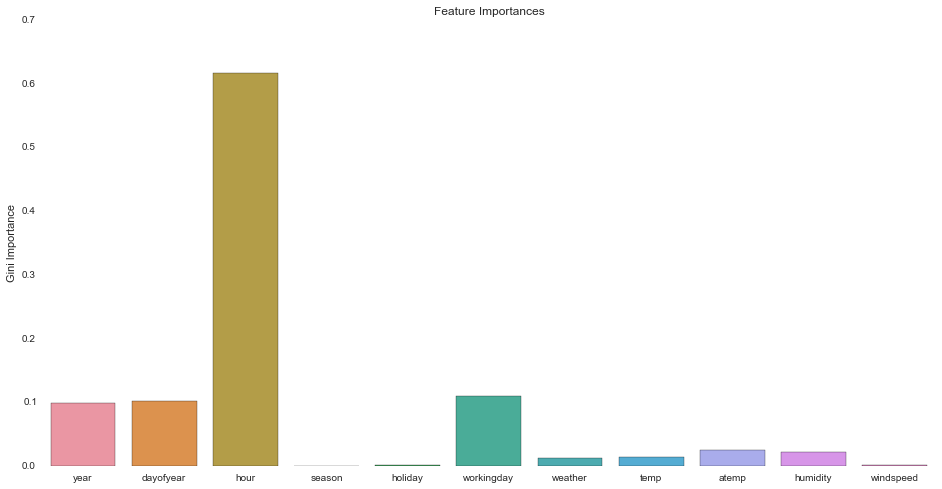

In [51]:
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df_train.columns.values[1:-3], y=dt_model.feature_importances_)
title = plt.title("Feature Importances")
ylabel = plt.ylabel("Gini Importance")

In [138]:
## Random Forest Regressor
# Ensure consistency of results
np.random.seed(0)

# Fit random forest regressor
rf_model = RandomForestRegressor(max_depth=20)
rf_model.fit(train_data_scaled, train_labels)
rf_preds = rf_model.predict(dev_data_scaled)

# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels, rf_preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels, rf_preds)))
print (np.round(rf_model.feature_importances_,3))

RMSLE: 0.337629845353
R-square on dev: 0.94813557973
[ 0.09   0.095  0.583  0.002  0.003  0.097  0.015  0.048  0.027  0.031
  0.01 ]


In [84]:
## Adaboost with Decision Tree Regressor
# Ensure consistency of results
np.random.seed(0)

# Fit Adaboost with decision tree regressor
ada_model = AdaBoostRegressor(n_estimators=5)
ada_model.fit(train_data_scaled, train_labels)
ada_preds = ada_model.predict(dev_data_scaled)

# RMSLE
print ("RMSLE: {}".format(RMSLE(dev_labels, ada_preds)))

# R2 for dev set
print ("R-square on dev: {}".format(metrics.r2_score(dev_labels, ada_preds)))
print (np.round(ada_model.feature_importances_,3))

RMSLE: 0.787777073209
R-square on dev: 0.569290213077
[ 0.161  0.048  0.681  0.     0.     0.01   0.     0.041  0.059  0.     0.   ]


In [40]:
# Write results in Kaggle format
# Predict with ALL training data (train set + dev set)
lr_model = LinearRegression()
lr_model.fit(X, Y)
kaggle_preds = lr_model.predict(test_data)
kaggle_preds[kaggle_preds<0] = 0

# Write to csv
out_path = '/Users/InfernoIX/datasets/bike/kaggle_submission.csv'
df_submission = pd.DataFrame({"datetime": df_test["datetime"], "count": kaggle_preds}, columns = ["datetime", "count"])
df_submission.to_csv(out_path, index=False)